In [3]:
%matplotlib inline
import sys, os 
sys.path.insert(0, os.path.expanduser('/Users/peadarcoyle/Code/pymc3'))
import theano
theano.config.floatX = 'float64'
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

data = pd.read_csv('/Users/peadarcoyle/Code/pymc3/pymc3/examples/data/radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values
n_counties = len(data.county.unique())

We'll form a hierarchical model.
And we'll use variational inference on it. 

In [4]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_counties)

    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [5]:
with hierarchical_model:
    means, sds, elbos = pm.variational.advi(n=10000)

Average ELBO = -3,401.8: 100%|██████████| 10000/10000 [00:01<00:00, 5324.49it/s]
Finished [100%]: Average ELBO = -3,192.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1,201.1:  24%|██▍       | 48552/200000 [00:08<00:27, 5512.49it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -1,114



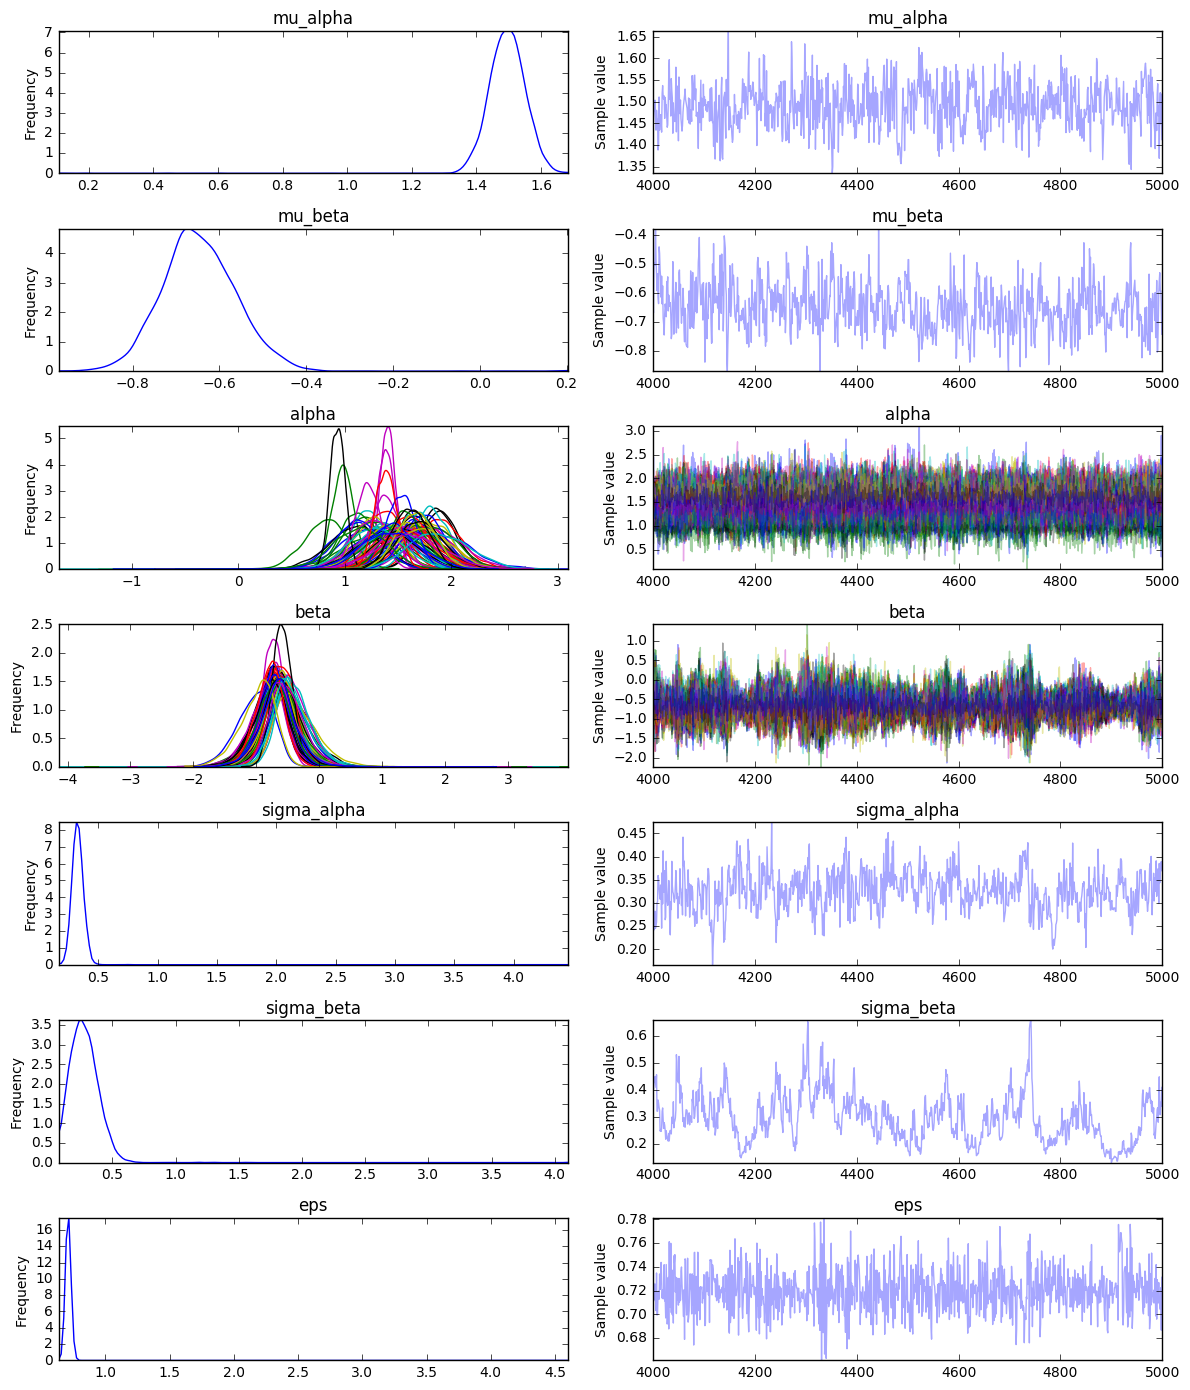

In [10]:

# Inference button (TM)!
with hierarchical_model:
    step = pm.NUTS(scaling=means)
    hierarchical_trace = pm.sample(5000, tune=1000, start=means, progressbar=False, live_plot=True)

In the above interference example you see that the Median ELBO converged. Once this happens you've fit your model. This is one of the advantages of Variational Inference. You have the power to know when your models converge. Unlike MCMC methods!!!

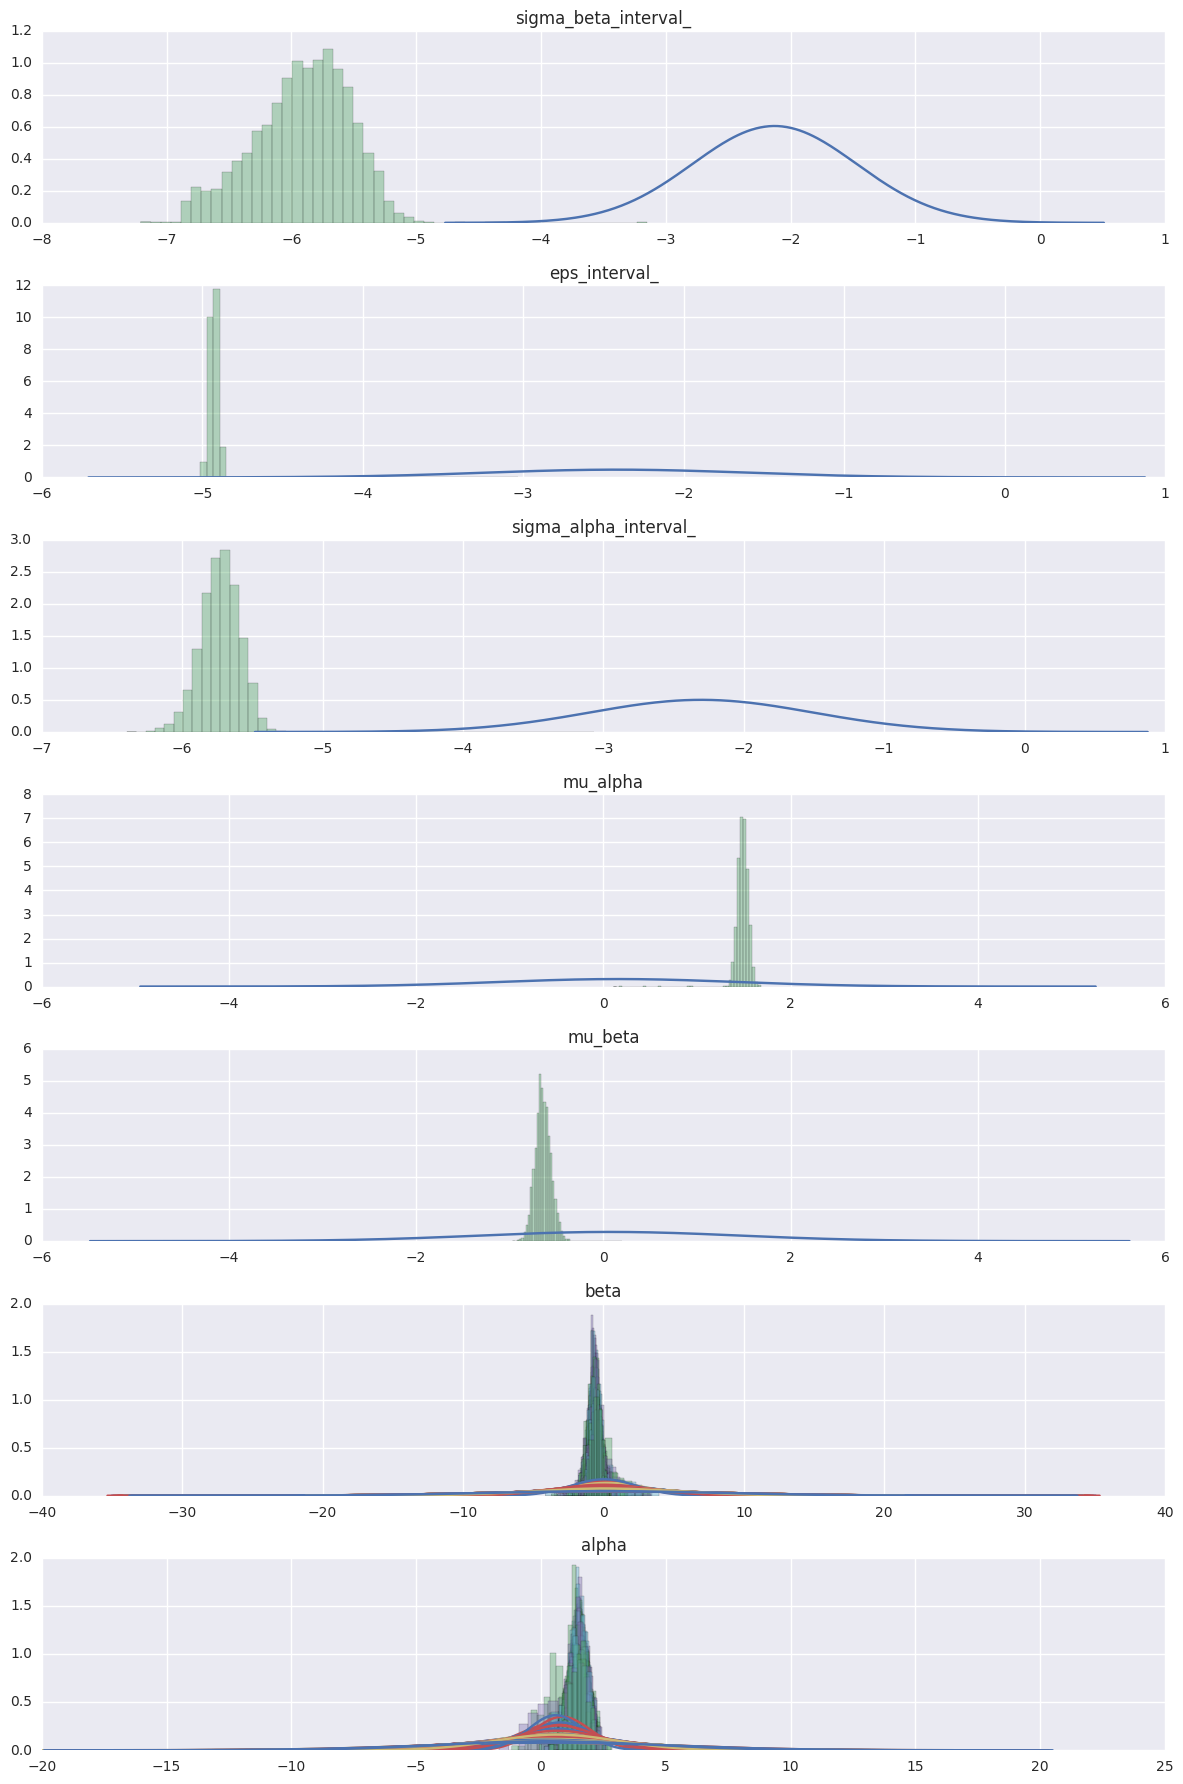

In [11]:
from scipy import stats
import seaborn as sns
varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        if hierarchical_trace[var].ndim > 1:
            t = hierarchical_trace[var][i]
        else:
            t = hierarchical_trace[var]
        sns.distplot(t, kde=False, norm_hist=True, ax=ax)
fig.tight_layout()

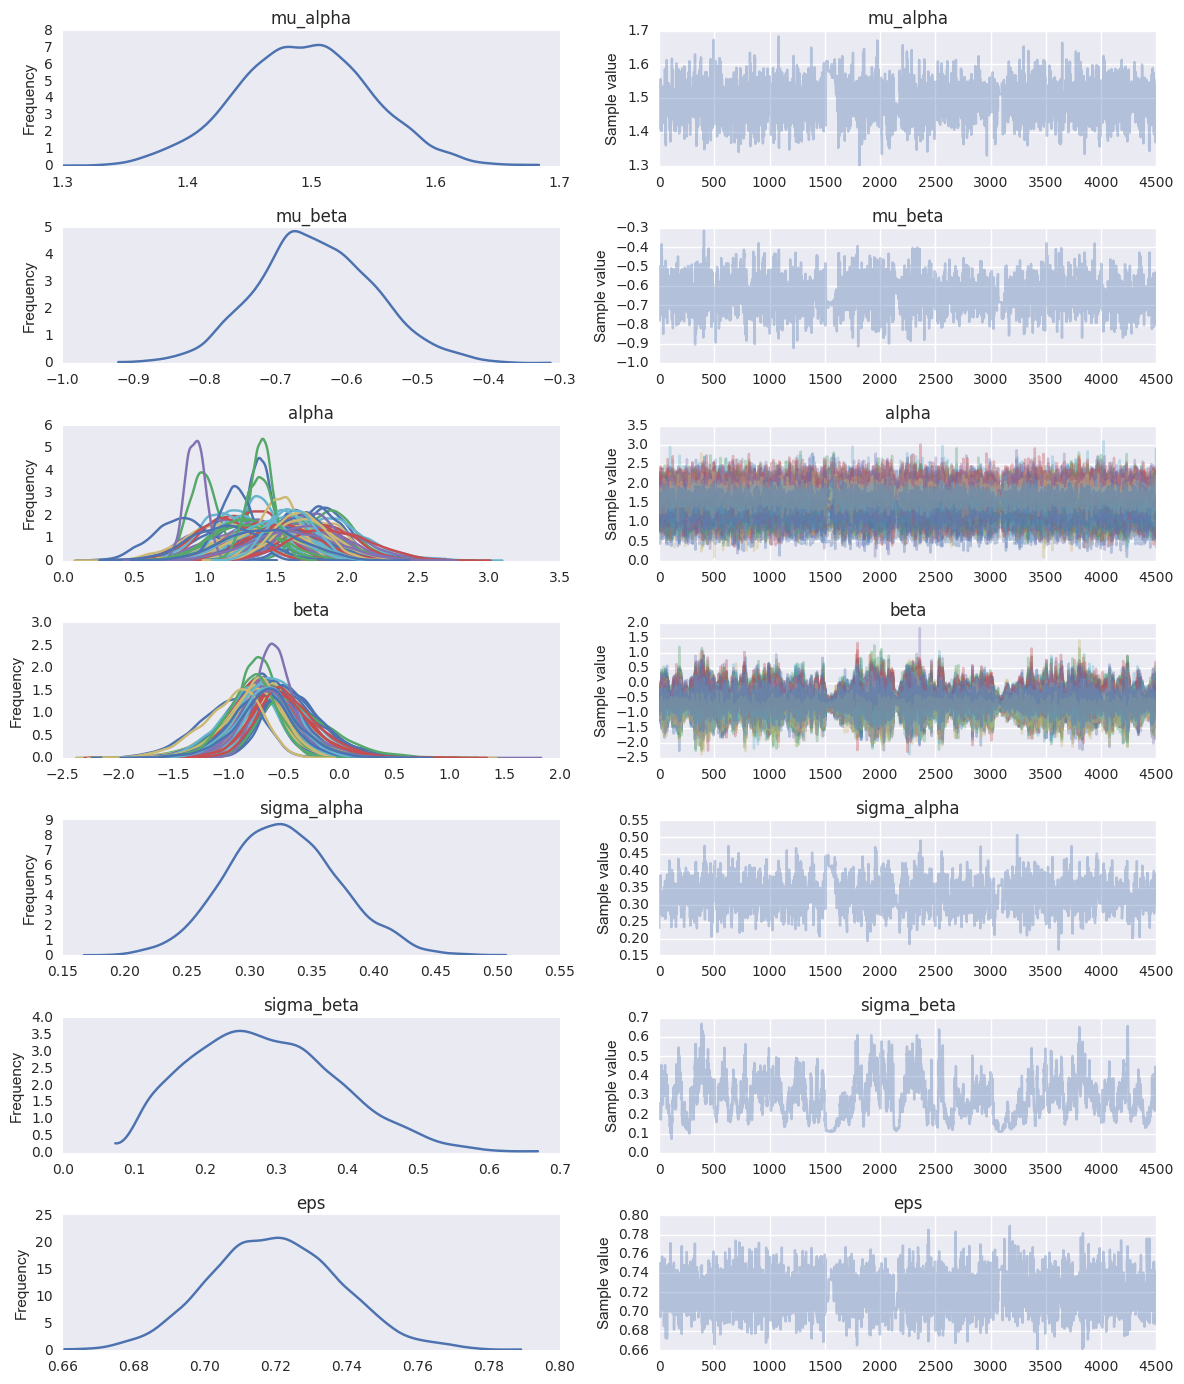

In [12]:
pm.traceplot(hierarchical_trace[500:]);


In [ ]:
# Non-hierarchical model runs
selection = ['CASS', 'CROW WING', 'FREEBORN']

indiv_traces = {}
for county_name in selection:
    # Select subset of data belonging to county
    c_data = data.ix[data.county == county_name]
    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values

    with pm.Model() as individual_model:
        # Intercept prior (variance == sd**2)
        a = pm.Normal('alpha', mu=0, sd=100**2)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=100**2)

        # Model error prior
        eps = pm.Uniform('eps', lower=0, upper=100)

        # Linear model
        radon_est = a + b * c_floor_measure

        # Data likelihood
        radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=c_log_radon)

        # Inference button (TM)!
        trace = pm.sample(2000, progressbar=False)

    # keep trace for later analysis
    indiv_traces[county_name] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -19.22: 100%|██████████| 200000/200000 [00:14<00:00, 13676.99it/s] 
Finished [100%]: Average ELBO = -19.219
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -37.902: 100%|██████████| 200000/200000 [00:16<00:00, 12449.86it/s]
Finished [100%]: Average ELBO = -37.903
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -35.029:  32%|███▏      | 64538/200000 [00:04<00:10, 12468.19it/s]

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = data.ix[data.county == c]
    c_ind = np.where(county_names==c)[0][0]
    c_data = c_data.reset_index(drop = True)
    z = list(c_data['county_code'])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(indiv_traces[c]['alpha'][500:], indiv_traces[c]['beta'][500:]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, indiv_traces[c]['alpha'][500:].mean() + indiv_traces[c]['beta'][500:].mean() * xvals,
                 'b', alpha=1, lw=2., label='individual')
    for a_val, b_val in zip(hierarchical_trace['alpha'][500:][z], hierarchical_trace['beta'][500:][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, hierarchical_trace['alpha'][500:][z].mean() + hierarchical_trace['beta'][500:][z].mean() * xvals,
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(c_data.floor + np.random.randn(len(c_data))*0.01, c_data.log_radon,
                    alpha=1, color='k', marker='.', s=80, label='original data')
    axis[i].set_xticks([0,1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i%3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')